In [218]:
import inspect
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [219]:
# UTILS FUNCTIONS

# This function returns the number of
# parameters of a given lambda function
def get_parameters_count(function):
    return len(inspect.signature(function).parameters)

# This function can extract a lambda function
# from a given string expression
def parse_lambda(expression):
    # Extracting t parameters as a sorted set
    t_vars = sorted(
        set(re.findall(r't\d+', expression)), 
        key=lambda x: int(x[1:])
    )
    # Creating parameters string with x in the beginning
    lambda_params = ['x'] + t_vars    
    string_params = ', '.join(lambda_params)
    
    string_lambda = f"lambda {string_params} : {expression}"

    # Replacing exponential expressions to make them compatible with Python syntax
    replacements = [
        ("e","np.e"),
        ("^","**") 
    ]

    for replacement in replacements:
        string_lambda = string_lambda.replace(*replacement)
        
    print(string_lambda)
    lambda_func = eval(string_lambda)
    return lambda_func

In [ ]:
# FITTING FUNCTIONS

# Chi-square
def chi2(y_obs, y_pred, y_err):
    return np.sum(((y_obs - y_pred) / y_err) ** 2)

# Fitting function with least squared method
# by minimizing chi-square function
def least_squared_fit(func, x, y, y_err, initial_guess):

    chi2_lambda = lambda params: chi2(y, func(x, *params), y_err)
    
    # Minimizing
    result = minimize(
        chi2_lambda, 
        initial_guess, 
        method="BFGS"
    )
    
    # Extracting error
    opt_parameters = result.x 
    cov_matrix = result.hess_inv
    errors = np.sqrt(np.diag(cov_matrix))
    
    return opt_parameters, errors

In [220]:

# Reading data
data_df = pd.read_csv('data.txt', sep='\t')

# Hypothesized functions
expressions = [
    "t0 * x^t1",
    "t0 + t1 * x + t2 * x^2",
    "t0 + t1 * x + t2 * e^x",
]

In [221]:
# Splitting data
x = data_df["x"].values
y = data_df["y_mean"].values
y_err = data_df["std"].values

results = []

# Fitting functions with LS
for expression in expressions:
    function = parse_lambda(expression)
    parameters_count = get_parameters_count(function) - 1 # Excluding x
    opt_params, error = least_squared_fit(function, x, y, y_err, [1] * parameters_count)

    # Adding results
    results.append((expression, function, opt_params, error))


lambda x, t0, t1 : t0 * x**t1
lambda x, t0, t1, t2 : t0 + t1 * x + t2 * x**2
lambda x, t0, t1, t2 : t0 + t1 * x + t2 * np.e**x



Results:
----------------------------------------
y = t0 * x^t1
Optimal parameters: 
	t0 = 1.777 
	t1 = 1.787 
Errors: 
	sigma_t0 = 0.030 
	sigma_t1 = 0.013 
Chi-square: 30.29336256907845
----------------------------------------
y = t0 + t1 * x + t2 * x^2
Optimal parameters: 
	t0 = 4.357 
	t1 = -2.389 
	t2 = 1.621 
Errors: 
	sigma_t0 = 0.768 
	sigma_t1 = 0.683 
	sigma_t2 = 0.125 
Chi-square: 9.119415622572454
----------------------------------------
y = t0 + t1 * x + t2 * e^x
Optimal parameters: 
	t0 = 1.140 
	t1 = 2.202 
	t2 = 0.175 
Errors: 
	sigma_t0 = 0.569 
	sigma_t1 = 0.336 
	sigma_t2 = 0.013 
Chi-square: 4.685277902502897


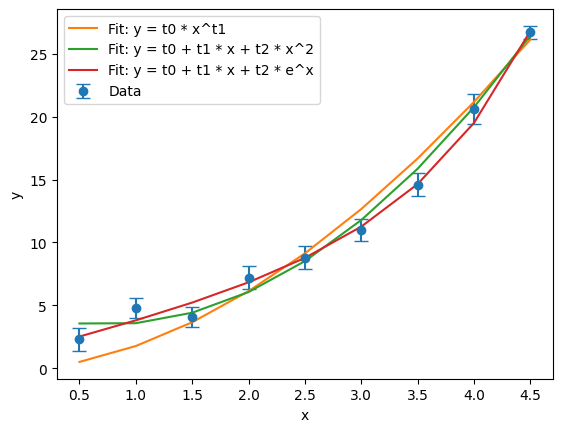

In [ ]:
# Showing results
print("\nResults:")

# Plotting data
plt.errorbar(x, y, yerr=y_err, fmt='o', label='Data', capsize=5)

# Plotting fitted functions
for result in results:
    expression = result[0]
    function = result[1]
    opt_params = result[2]
    error = result[3]

    string_opt_params = ""
    for i, value in enumerate(opt_params):
        string_opt_params += f"\n\tt{i} = {value:.3f} "

    string_errors = ""
    for i, value in enumerate(error):
        string_errors += f"\n\tsigma_t{i} = {value:.3f} "

    y_pred = function(x, *opt_params)

    print("----------------------------------------")
    print(f"y = {expression}")
    print(f"Optimal parameters: {string_opt_params}")
    print(f"Errors: {string_errors}")
    print(f"Chi-square: {chi2(y, y_pred, y_err)}")
    plt.plot(x, function(x, *opt_params), label=f'Fit: y = {expression}')


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
